# Fine Tuning BERT

In [ ]:
# Installing the transformers library and additional libraries if looking process

!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.7 MB/s eta 0:00:00


In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig


In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
#device = 'cpu'

### Importing the data


In [ ]:
# Import the csv into pandas dataframe and add the headers
df_train = pd.read_excel('/content/Train_set.xlsx')
df_val = pd.read_excel('/content/Validation_set.xlsx')
df_test = pd.read_excel('/content/Test_set.xlsx')


# Removing unwanted columns and only leaving title of news and the category which will be the target
df_train = df_train[['Categorización','Comentarios_limpios']]
df_val = df_val[['Categorización','Comentarios_limpios']]
df_test = df_test[['Categorización','Comentarios_limpios']]


# Converting the codes to appropriate categories using a dictionary
my_dict = {
    'MALO':'negative',
    'MIXTO':'neutral',
    'BUENO':'positive'
}

def update_cat(x):
    return my_dict[x]

df_train['CATEGORY'] = df_train['Categorización'].apply(lambda x: update_cat(x))
df_val['CATEGORY'] = df_val['Categorización'].apply(lambda x: update_cat(x))
df_test['CATEGORY'] = df_test['Categorización'].apply(lambda x: update_cat(x))

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df_train['ENCODE_CAT'] = df_train['CATEGORY'].apply(lambda x: encode_cat(x))
df_train = df_train[["Comentarios_limpios", "CATEGORY", "ENCODE_CAT"]]

df_val['ENCODE_CAT'] = df_val['CATEGORY'].apply(lambda x: encode_cat(x))
df_val = df_val[["Comentarios_limpios", "CATEGORY", "ENCODE_CAT"]]

df_test['ENCODE_CAT'] = df_test['CATEGORY'].apply(lambda x: encode_cat(x))
df_test = df_test[["Comentarios_limpios", "CATEGORY", "ENCODE_CAT"]]

In [ ]:
# Using get_dummies to create dummy variables
df_dummies_train = pd.get_dummies(df_train['ENCODE_CAT'])

# Concatenating the dummy variables with the original DataFrame
df_train = pd.concat([df_train, df_dummies_train], axis=1)
df_train['list'] = df_train[df_train.columns[3:]].values.tolist()
df_train = df_train[['Comentarios_limpios', 'list']]
df_train.head()

,Comentarios_limpios,list
0,pasar clase necesita ademas foro escribir refe...,"[1, 0, 0]"
1,gustaria cuestionarios tipo examen examenes pr...,"[1, 0, 0]"
2,incluir actividades grupales interactivas proc...,"[1, 0, 0]"
3,considero falto ayuda parte poder enterder bie...,"[1, 0, 0]"
4,juan desorganizado respecto imparte clases hab...,"[1, 0, 0]"


In [ ]:
# Using get_dummies to create dummy variables
df_dummies_val = pd.get_dummies(df_val['ENCODE_CAT'])

# Concatenating the dummy variables with the original DataFrame
df_val = pd.concat([df_val, df_dummies_val], axis=1)
df_val['list'] = df_val[df_val.columns[3:]].values.tolist()
df_val = df_val[['Comentarios_limpios', 'list']]
df_val.head()

,Comentarios_limpios,list
0,bueno explicando hace bastante claridad si con...,"[1, 0, 0]"
1,atento siento falto contenido clase comparado ...,"[1, 0, 0]"
2,creo puede mejorar organizando mejor rtiempo m...,"[1, 0, 0]"
3,retire materia tiempo di cuenta jose domina bi...,"[1, 0, 0]"
4,mejore organizacion informacion d2l,"[1, 0, 0]"


In [ ]:
# Using get_dummies to create dummy variables
df_dummies_test = pd.get_dummies(df_test['ENCODE_CAT'])

# Concatenating the dummy variables with the original DataFrame
df_test = pd.concat([df_test, df_dummies_test], axis=1)
df_test['list'] = df_test[df_test.columns[3:]].values.tolist()
df_test = df_test[['Comentarios_limpios', 'list']]
df_test.head()

,Comentarios_limpios,list
0,profe explico temas asertividad embargo pienso...,"[1, 0, 0]"
1,buen profe domina tema existe pequena dificult...,"[1, 0, 0]"
2,buen profesor embargo considero flexibilidad i...,"[1, 0, 0]"
3,parece metodologia usada jose personal permiti...,"[1, 0, 0]"
4,requiere mejor explicacion informes seminarios...,"[1, 0, 0]"


### Preparing the Dataset and Dataloader


In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
EPOCHS = 4
LEARNING_RATE = 2e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Comentarios_limpios
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
# Creating the dataset and dataloader for the neural network

print("TRAIN Dataset: {}".format(df_train.shape))
print("VALIDATION Dataset: {}".format(df_val.shape))
print("TESTING Dataset: {}".format(df_test.shape))

training_set = CustomDataset(df_train, tokenizer, MAX_LEN)
validation_set = CustomDataset(df_val, tokenizer, MAX_LEN)
testing_set = CustomDataset(df_test, tokenizer, MAX_LEN)

TRAIN Dataset: (3153, 2)
VALIDATION Dataset: (1050, 2)
TESTING Dataset: (1053, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

validation_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **validation_params)
testing_loader = DataLoader(testing_set, **validation_params)

### Creating the Neural Network for Fine Tuning

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

### Fine Tuning the Model


In [ ]:
from sklearn.metrics import accuracy_score

loss_train_final = []

def train(epoch):
    model.train()
    train_targets=[]
    train_outputs=[]
    loss_train = []

    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        train_targets.extend(targets)
        train_targets_np = [tensor.cpu().numpy().tolist() for tensor in train_targets]
        train_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())


        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss_train.append(loss.item())
        if _%5000==0:
            print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Convert lists to numpy arrays
    train_outputs_np = (np.array(train_outputs) > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Calculate the accuracy

    average_loss = sum(loss_train) / len(loss_train)
    loss_train_final.append(average_loss)


    return train_targets_np, train_outputs_np, loss_train_final

### Validating the Model


In [ ]:
loss_valid_final = []

def validation(epoch, validation_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    loss_valid = []

    with torch.no_grad():
        for _, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)


            loss = loss_fn(outputs, targets)
            loss_valid.append(loss.item())
            if _%5000==0:
              print(f'Epoch: {epoch}, Validation Loss:  {loss.item()}')


            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        average_loss = sum(loss_valid) / len(loss_valid)
        loss_valid_final.append(average_loss)

    return fin_outputs, fin_targets, loss_valid_final

In [ ]:
acc_train_list = []
acc_val_list = []
best_accuracy_train = 0
best_accuracy_val = 0
# le agregué el validation_loader tanto a la función de valid como al validation en el for loop

for epoch in range(EPOCHS):
    outputs_train, targets_train, loss_list_train = train(epoch)
    accuracy_train = metrics.accuracy_score(targets_train, outputs_train)
    acc_train_list.append(accuracy_train)
    print(f" Training Accuracy Score = {accuracy_train}")

    if best_accuracy_train < accuracy_train:
      predictions_final_train = outputs_train
      targets_list_final_train = targets_train

    best_accuracy_train = accuracy_train


    outputs, targets, loss_list_val = validation(epoch, validation_loader)
    binary_list = [[1 if value == max(inner_list) else 0 for value in inner_list] for inner_list in outputs]
    accuracy_val = metrics.accuracy_score(targets, binary_list)
    acc_val_list.append(accuracy_val)
    print(f" Validation Accuracy Score = {accuracy_val}")

    if best_accuracy_val < accuracy_val:

      predictions_final_valid = binary_list
      targets_list_final_valid = targets

    best_accuracy_val = accuracy_val

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Training Loss:  0.7189886569976807
 Training Accuracy Score = 0.25023786869647957
Epoch: 0, Validation Loss:  0.5111511945724487


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.6304761904761905
Epoch: 1, Training Loss:  0.606870174407959


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.6152870282270854
Epoch: 1, Validation Loss:  0.3664494752883911


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.6638095238095238
Epoch: 2, Training Loss:  0.6335503458976746


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.7526165556612749
Epoch: 2, Validation Loss:  1.2320995330810547


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7542857142857143
Epoch: 3, Training Loss:  0.12655964493751526


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.8319061211544561
Epoch: 3, Validation Loss:  0.1558579057455063


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7476190476190476
Epoch: 4, Training Loss:  0.24814319610595703


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.8702822708531557
Epoch: 4, Validation Loss:  0.16824202239513397


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.758095238095238
Epoch: 5, Training Loss:  0.07809796929359436


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9191246431969553
Epoch: 5, Validation Loss:  0.6606254577636719


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7723809523809524
Epoch: 6, Training Loss:  0.02480037324130535


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.937836980653346
Epoch: 6, Validation Loss:  0.35535937547683716


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7714285714285715
Epoch: 7, Training Loss:  0.021093493327498436


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.956232159847764
Epoch: 7, Validation Loss:  1.4421184062957764


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7276190476190476
Epoch: 8, Training Loss:  0.04477807506918907


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9575007928956549
Epoch: 8, Validation Loss:  0.4585888385772705


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7390476190476191
Epoch: 9, Training Loss:  0.008209886029362679


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.975895972090073
Epoch: 9, Validation Loss:  0.012956984341144562


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7533333333333333
Epoch: 10, Training Loss:  0.009546933695673943


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9686013320647003
Epoch: 10, Validation Loss:  0.7797030210494995


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7495238095238095
Epoch: 11, Training Loss:  0.01029559038579464


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9793847129717729
Epoch: 11, Validation Loss:  0.740416944026947


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7428571428571429
Epoch: 12, Training Loss:  0.04722011089324951


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9768474468759911
Epoch: 12, Validation Loss:  0.004638004116714001


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7561904761904762
Epoch: 13, Training Loss:  0.005473884753882885


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9771646051379639
Epoch: 13, Validation Loss:  1.0732967853546143


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7561904761904762
Epoch: 14, Training Loss:  0.005262814462184906


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9857278782112274
Epoch: 14, Validation Loss:  0.06865657866001129


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7523809523809524
Epoch: 15, Training Loss:  0.004611584357917309


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9850935616872819
Epoch: 15, Validation Loss:  0.009159895591437817


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.76
Epoch: 16, Training Loss:  0.003374130232259631


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.987313669521091
Epoch: 16, Validation Loss:  0.8650082349777222


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7552380952380953
Epoch: 17, Training Loss:  0.00887416023761034


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9857278782112274
Epoch: 17, Validation Loss:  1.2124245166778564


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7476190476190476
Epoch: 18, Training Loss:  0.007813435047864914


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9866793529971456
Epoch: 18, Validation Loss:  0.00160918477922678


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7676190476190476
Epoch: 19, Training Loss:  0.007414692547172308


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Training Accuracy Score = 0.9800190294957184
Epoch: 19, Validation Loss:  0.18907973170280457


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Validation Accuracy Score = 0.7447619047619047


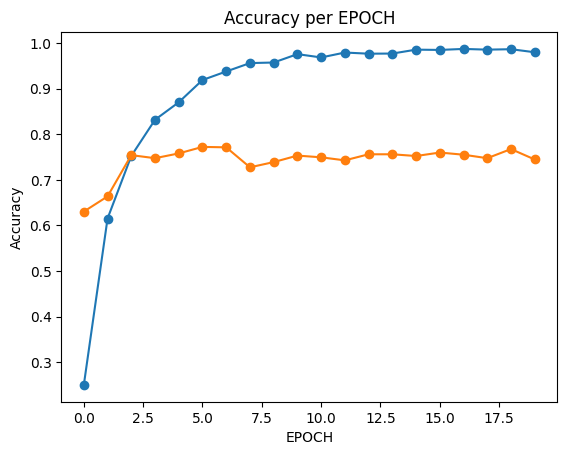

In [ ]:
import matplotlib.pyplot as plt

# Sample data

x = []

for i in range(EPOCHS):
  x.append(i)

# Create the line plot
plt.plot(x, acc_train_list, marker='o')
plt.plot(x, acc_val_list, marker='o')

# Add title and labels
plt.title('Accuracy per EPOCH')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

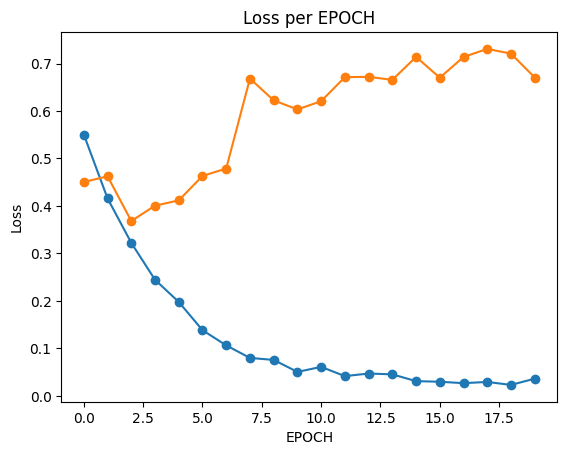

In [ ]:
# Create the line plot
plt.plot(x, loss_list_train, marker='o')
plt.plot(x, loss_list_val, marker='o')

# Add title and labels
plt.title('Loss per EPOCH')
plt.xlabel('EPOCH')
plt.ylabel('Loss')

# Display the plot
plt.show()

In [ ]:
def outputs_labels (outputs):
    for i in outputs:
      if i[0] == 1:
        i[0] = 0

      elif i[1] == 1:
        i[1] = 1

      elif i[2] == 1:
        i[2] = 2

    return outputs

In [ ]:
outputs_train = outputs_labels(predictions_final_train)
targets_train = outputs_labels(targets_list_final_train)
outputs_val = outputs_labels(predictions_final_valid)
targets_val = outputs_labels(targets_list_final_valid)

In [ ]:
outputs_train = [max(sublist) for sublist in outputs_train]
targets_train = [max(sublist) for sublist in targets_train]
outputs_val = [max(sublist) for sublist in outputs_val]
targets_val = [max(sublist) for sublist in targets_val]

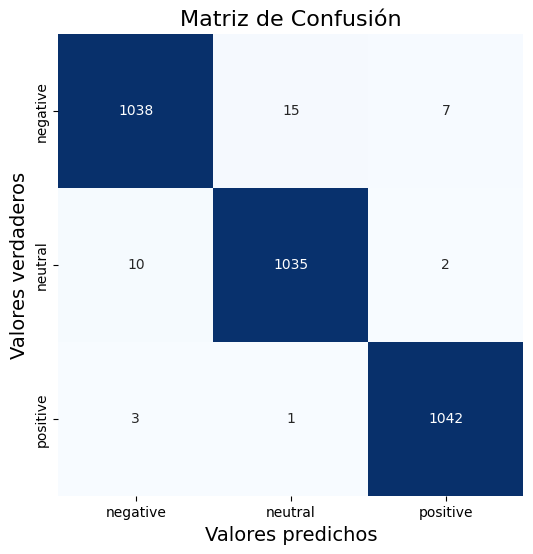

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_mapping[val] for val in outputs_train]
labels_graph = ["negative", "neutral", "positive"]

# NOTA: Cambiar el número de la lista de eval_labels y eval_predictions por el epoch de mayor acc

labels = [label_mapping[val] for val in targets_train]


cm = confusion_matrix(labels, predicted_labels, labels = labels_graph)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_graph,
                yticklabels=labels_graph)
plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

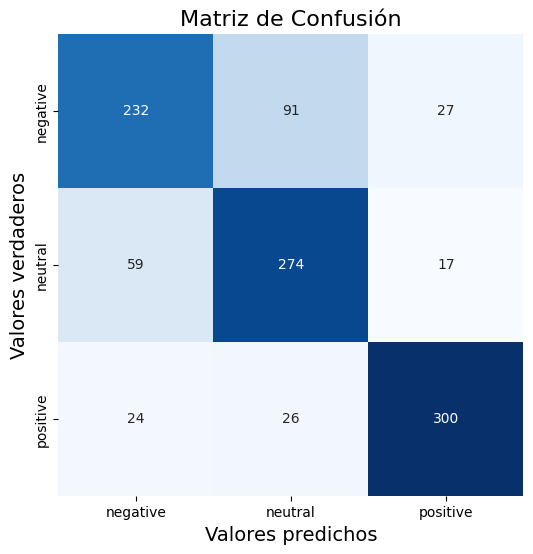

In [ ]:
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_mapping[val] for val in outputs_val]
labels_graph = ["negative", "neutral", "positive"]

# NOTA: Cambiar el número de la lista de eval_labels y eval_predictions por el epoch de mayor acc

labels = [label_mapping[val] for val in targets_val]


cm = confusion_matrix(labels, predicted_labels, labels = labels_graph)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_graph,
                yticklabels=labels_graph)
plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

### Testing the model

In [ ]:
EPOCHS = 1
acc_val_list_test = []


for epoch in range(EPOCHS):

    outputs_test, targets_test, loss_list_test = validation(epoch, testing_loader)
    binary_list_test = [[1 if value == max(inner_list) else 0 for value in inner_list] for inner_list in outputs_test]
    accuracy_test = metrics.accuracy_score(targets_test, binary_list_test)
    acc_val_list_test.append(accuracy_test)
    print(f" Testing Accuracy Score = {accuracy_test}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Validation Loss:  1.1506686210632324
 Testing Accuracy Score = 0.7312440645773979


In [ ]:
outputs_test = outputs_labels(binary_list_test)
targets_test = outputs_labels(targets_test)
outputs_test = [max(sublist) for sublist in outputs_test]
targets_test = [max(sublist) for sublist in targets_test]

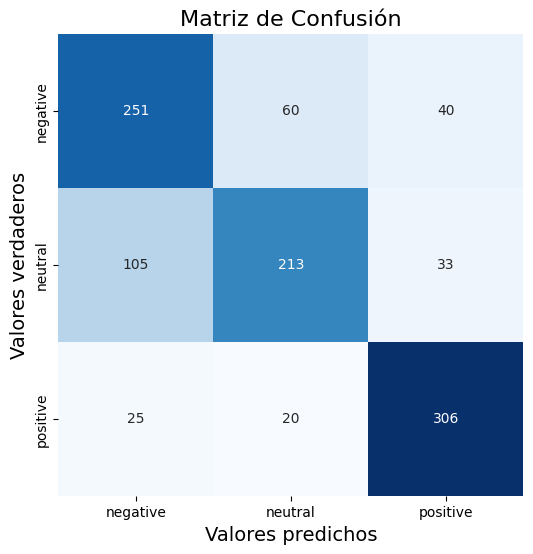

In [ ]:
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_mapping[val] for val in outputs_test]
labels_graph = ["negative", "neutral", "positive"]


labels = [label_mapping[val] for val in targets_test]


cm = confusion_matrix(labels, predicted_labels, labels = labels_graph)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_graph,
                yticklabels=labels_graph)
plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

### Saving the Trained Model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Saving the files for re-use

output_model_file = '/content/drive/MyDrive/Tesis/Jose/pytorch_BERT_et.bin'
output_vocab_file = '/content/drive/MyDrive/Tesis/Jose/vocab_BERT_et.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed
